In [1]:
import sys
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
import numpy as np, scipy as sp, scipy.stats, os, sys, joblib
import os, numpy as np, scipy as sp, scipy.io, scipy.io.wavfile
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import random
import pandas as pd
import importlib
import useful_functions
import preprocessing_functions
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2023-07-09 14:41:30.259471: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-09 14:41:30.279761: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-09 14:41:30.588492: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Num GPUs Available:  1


2023-07-09 14:41:31.647741: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-09 14:41:31.660536: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-09 14:41:31.660626: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [2]:
importlib.reload(useful_functions)
importlib.reload(preprocessing_functions)
from useful_functions import *
from preprocessing_functions import *

In [3]:
 # Define the data and model foldes.
data_folder = r"../training_data"
model_folder = r"../model"
wind_size = 4000
verbose = 3

In [4]:
recordings,patient_label,patient_id = create_rec_patient_list(data_folder)
df = build_dataset_df(recordings,patient_id,patient_label,wind_size)
df.head()

,patient_id,recording_type,recording,murmur
0,2530.0,1.0,"[-425, 1045, 518, -674, -690, -588, -237, -276...",0.0
1,2530.0,1.0,"[42, -38, -91, -62, 41, 198, 225, 49, -53, -49...",0.0
2,2530.0,1.0,"[-141, -296, -99, 62, 113, 186, 301, 350, 179,...",0.0
3,2530.0,1.0,"[22, -1, -48, 83, 160, 192, 345, 520, 650, 652...",0.0
4,2530.0,1.0,"[-369, -367, -359, -404, -389, -354, -290, -27...",0.0


In [5]:
# check correctness of dataframe loaded
for i in range(68261):
  if len(df["recording"][i]) != wind_size:
    print("problem sir")

In [6]:
# select only two columns
new_df = df[['patient_id', 'murmur']]
new_df = new_df.drop_duplicates()
new_df = new_df.reset_index(drop=True)

In [7]:
# check murmur/non-murmur balance
nb_murmur_present = (new_df.loc[new_df['murmur'] == 1]).shape[0]
nb_murmur_absent = (new_df.loc[new_df['murmur'] == 0]).shape[0]
print(nb_murmur_present)
print(nb_murmur_absent)

179
695


In [35]:
# display
new_df

,patient_id,murmur
0,2530.0,0.0
1,9979.0,1.0
2,13918.0,1.0
3,14241.0,1.0
4,14998.0,0.0
...,...,...
869,85340.0,0.0
870,85341.0,0.0
871,85343.0,1.0
872,85345.0,0.0


In [36]:
# complete list of distinct patient id's and corresponding label
list_id = new_df['patient_id']
list_label = new_df['murmur']

In [37]:
# function for building
def get_balanced_lists(X,y):
    ones = np.where(np.array(y)==1)
    zeros = np.where(np.array(y)==0)
    ones = ones[0]  # because this a [[list of indexes]]
    zeros = zeros[0]
    trunc = ones.shape[0] - zeros.shape[0]
    zeros = zeros[:trunc]
    new_X=[]
    new_y=[]
    for i in ones:
        new_X.append(X[i])
        new_y.append(y[i])
    for j in zeros:
        new_X.append(X[j])
        new_y.append(y[j])
    return new_X,new_y

In [38]:
# list_id/label updated in order to be balenced (in terms of nb of patient with murmur/no_murmur
list_id,list_label = get_balanced_lists(list_id,list_label)

In [39]:
id_train, id_valtest, label_train, label_valtest = train_test_split(list_id, list_label , test_size=0.3, random_state=42)
id_val, id_test, label_val, label_test = train_test_split(id_valtest, label_valtest , test_size=0.5, random_state=42)

In [40]:
def select_rows(id_list,dframe):
  #for id in list_id:
  sub_df = dframe.loc[dframe['patient_id'].isin([int(id) for id in id_list])]
  return sub_df

df_train = select_rows(id_train,df)
df_val = select_rows(id_val,df)
df_test = select_rows(id_test,df)

In [41]:
(df_train.loc[df_train['murmur'] == 0]).shape[0]

10879

In [42]:
X_train = np.vstack(df_train['recording'])
y_train = np.array(df_train['murmur'])

X_val = np.vstack(df_val['recording'])
y_val = np.array(df_val['murmur'])

X_test = np.vstack(df_test['recording'])
y_test = np.array(df_test['murmur'])

In [43]:
X_train = X_train.reshape(len(X_train),len(X_train[1]),1)
X_val = X_val.reshape(len(X_val),len(X_val[1]),1)
X_test = X_test.reshape(len(X_test),len(X_test[1]),1)

In [44]:
X_train.shape

(20122, 4096, 1)

In [45]:
def make_model(input_shape):
    drop_rate = 0.2
    input_layer = tf.keras.layers.Input(shape=(input_shape[0],input_shape[1]))

    x = tf.keras.layers.Conv1D(filters=32, kernel_size=3, padding="same",activation='relu')(input_layer)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool1D(2,padding="same")(x)
    x = tf.keras.layers.Dropout(0.4)(x)

    x = tf.keras.layers.Conv1D(filters=64, kernel_size=3, padding="same",activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    x = tf.keras.layers.Conv1D(filters=128, kernel_size=3, padding="same",activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    """
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    """
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.4)(x)

    x = tf.keras.layers.Dense(32, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    output_layer = tf.keras.layers.Dense(1, activation="sigmoid")(x)

    return tf.keras.models.Model(inputs=input_layer, outputs=output_layer)


model = make_model(input_shape=X_train.shape[1:])

In [46]:

model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 4096, 1)]         0         
                                                                 
 conv1d_3 (Conv1D)           (None, 4096, 32)          128       
                                                                 
 batch_normalization_5 (Batc  (None, 4096, 32)         128       
 hNormalization)                                                 
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 2048, 32)         0         
 1D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 2048, 32)          0         
                                                                 
 conv1d_4 (Conv1D)           (None, 2048, 64)          6208

In [47]:

epochs = 100
batch_size = 32

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=10, min_lr=0.0001
    ),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    #optimizer=opt,
    loss="binary_crossentropy",
    metrics=["acc"],
    #metrics=[tf.keras.metrics.CategoricalAccuracy(name='acc')],
)
history = model.fit(
    X_train,
    np.array(y_train),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=(X_val,np.array(y_val)),
    verbose=1,
)

Epoch 1/100
629/629 [==============================] - 7s 9ms/step - loss: 0.6843 - acc: 0.6264 - val_loss: 0.6709 - val_acc: 0.5986 - lr: 0.0010
Epoch 2/100
629/629 [==============================] - 5s 8ms/step - loss: 0.6307 - acc: 0.6568 - val_loss: 0.6604 - val_acc: 0.5936 - lr: 0.0010
Epoch 3/100
629/629 [==============================] - 5s 7ms/step - loss: 0.6100 - acc: 0.6741 - val_loss: 0.6741 - val_acc: 0.6005 - lr: 0.0010
Epoch 4/100
629/629 [==============================] - 5s 8ms/step - loss: 0.6014 - acc: 0.6831 - val_loss: 0.7393 - val_acc: 0.5460 - lr: 0.0010
Epoch 5/100
629/629 [==============================] - 5s 7ms/step - loss: 0.5971 - acc: 0.6812 - val_loss: 0.6833 - val_acc: 0.5892 - lr: 0.0010
Epoch 6/100
629/629 [==============================] - 5s 8ms/step - loss: 0.5906 - acc: 0.6903 - val_loss: 0.6796 - val_acc: 0.5870 - lr: 0.0010
Epoch 7/100
629/629 [==============================] - 4s 7ms/step - loss: 0.5864 - acc: 0.6889 - val_loss: 0.6559 - val_acc

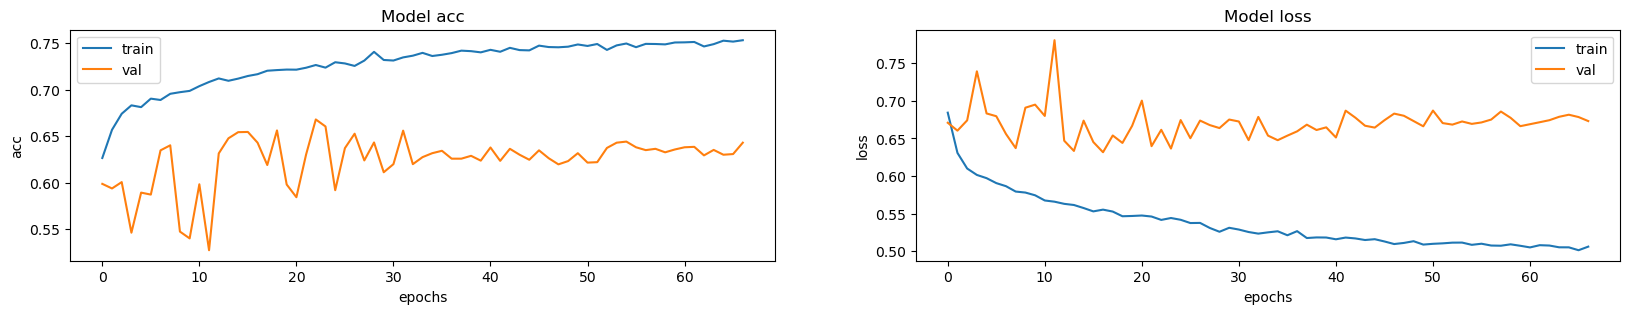

In [48]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['acc', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [49]:
score = model.evaluate(X_test, y_test, verbose = 0) 

print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

Test loss: 0.6617811322212219
Test accuracy: 0.6359519958496094


In [50]:
pred = model.predict(X_test)
print(pred)

139/139 [==============================] - 0s 887us/step
[[0.6885435 ]
 [0.36644828]
 [0.49301448]
 ...
 [0.5248375 ]
 [0.41363683]
 [0.07707138]]


In [51]:
def check_max_pred(prd):
  max=0
  for i in prd:
    if i[0] > max:
      max = i[0]
  print(max)

In [52]:
check_max_pred(pred)

0.99863523


In [53]:
list_patient_rows = list(df_test.groupby(['patient_id'])['patient_id'].count())

In [54]:
def cumulative(lists): 
    cu_list = [] 
    length = len(lists) 
    cu_list = [sum(lists[0:x:1]) for x in range(0, length+1)] 
    return cu_list[1:]

In [55]:
pred_groupby_patient = np.split(pred,cumulative(list_patient_rows))
pred_groupby_patient = pred_groupby_patient[:-1]

df_test = df_test.astype({'murmur':'int'})
y_test_grouped = df_test[['patient_id','murmur']].drop_duplicates()['murmur'].to_list()

In [56]:
def mean_pred(prediction):
  pred = []
  for i in prediction:
    lst = [ j[0] for j in i]
    avg = sum(lst)/len(lst)
    if avg > 0.5:
      pred.append(1)
    else:
      pred.append(0)
  return pred

def majority_pred(prediction):
  pred = []
  for i in prediction:
    lst = [ j[0] for j in i]
    if (sum(elem > 0.5 for elem in lst)) > (len(lst)/2):
      pred.append(1)
    else:
      pred.append(0)
  return pred


In [57]:
pred1 = mean_pred(pred_groupby_patient)
pred2 = majority_pred(pred_groupby_patient)



In [29]:
print(pred1)
print(pred2)
print(y_test_grouped)
print("Accuracy score of mean_pred : ",accuracy_score(pred1 , y_test_grouped))
print("Accuracy score of majority_pred : ",accuracy_score(pred2 , y_test_grouped))

[0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0]
[0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0]
[0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Accuracy score of mean_pred :  0.6851851851851852
Accuracy score of majority_pred :  0.6481481481481481
